# Imports and library functions

In [253]:
from dataclasses import dataclass
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from ydata_profiling import ProfileReport

from lib.chartSpecificData import survivalFrame
from lib.clean import cleanAge, cleanEmbarked, cleanFare, dropIrrelevant
from lib.featureEngineering import addFamilyCountData
from lib.numericConversion import (SexConversion, embarkedConverter,
                                   sexConverter)

### matplotlib options

This is just because my local setup is weird

In [254]:
matplotlib.use("ipympl")
plt.ioff()

## Compose
a function that enables functional composition
compose :: function, function, ... -> function

compose(f, g, h, i)(x) is equivalent to i(h(g(f(x))))

In [255]:
def compose(*funcs):
    return reduce(lambda f, g: lambda x: g(f(x)), funcs, lambda x: x)

## Import The Data

In [256]:

data: DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv"
)

## Data Exploration part 1

### Get the first few rows

In [257]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Get the last few rows

In [258]:
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### Get summary, data types, that sort of thing

In [259]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Get descriptive statistics

In [260]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Get number of nulls

In [261]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### ydataprofiler

In [262]:
# ProfileReport(data, title="Titanic Profiling Report")

# Data Preprocessing

Here we are just getting rid of null values and dropping irrelevant data that we don't need

In [263]:
cleanData = compose(cleanAge, cleanFare, cleanEmbarked, dropIrrelevant)
convertDataToNumeric = compose(sexConverter, embarkedConverter)

processedData = compose(cleanData, convertDataToNumeric)(data)
processedDataRows = len(processedData)

# Data Exploration Part II and Data Visualization

### ydata profiler again because catagorical data sucks

In [264]:
# ProfileReport(processedData, title="Titanic Profiling Report")

### Correlation Graph

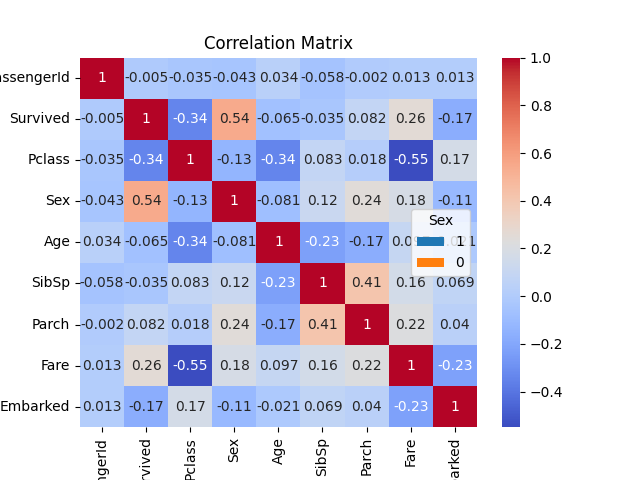

In [265]:
processedDataCorrMatrix = processedData.corr().round(3)
sns.heatmap(processedDataCorrMatrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Survival by Sex

In [267]:


survivalFrame("Sex", processedData).rename(columns={1: "Female", 0: "Male"})
# sexSurvival = sns.barplot(x="Sex", y="Survived", data=processedData)
# sexSurvival.set_xticks(range(2))
# sexSurvival.set_xticklabels(["Male", "Female"])
# sexSurvival.set_yticks()

Sex,Female,Male
Survived,233,109
Dead,81,468
